In [1]:
# from openbb_terminal.sdk import openbb
from prophet import Prophet
from fastquant import backtest
from alpha_vantage.timeseries import TimeSeries
from xgboost import Booster
from sklearn.model_selection import TimeSeriesSplit
from dotenv import load_dotenv
from datetime import datetime, timedelta
from polygon import RESTClient
from plotly.offline import plot
from polygon.rest.models import (
    TickerNews,
)
from twelvedata import TDClient

import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import databento as db

import nasdaqdatalink
import quandl
import os
import polygon
import requests
import finnhub

load_dotenv('.env')

True

In [2]:
quandl.ApiConfig.api_key = os.environ['quandl']
nasdaqdatalink.read_key(filename='./.nasdaq_key')

# Data Loading

## OpenBB

In [3]:
df = openbb.futures.historical('CL', '2020-11-20', '2023-11-20')
df

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-20,41.700001,42.320000,41.509998,42.150002,42.150002,276340
2020-11-23,42.459999,43.360001,42.290001,43.060001,43.060001,300717
2020-11-24,42.840000,45.200001,42.820000,44.910000,44.910000,418527
2020-11-25,44.820000,46.259998,44.730000,45.709999,45.709999,417182
2020-11-27,45.900002,46.090000,44.549999,45.529999,45.529999,365128
...,...,...,...,...,...,...
2023-11-13,77.150002,78.639999,76.209999,78.260002,78.260002,262903
2023-11-14,78.529999,79.769997,77.790001,78.260002,78.260002,263002
2023-11-15,78.169998,78.769997,76.309998,76.660004,76.660004,282301


In [4]:
openbb.keys.av(key=os.environ['alphavantage'], persist=True)
openbb.keys.databento(key=os.environ['databento'], persist=True)
# https://docs.openbb.co/sdk/usage/basics
df = openbb.stocks.load(symbol='SPY', source='DataBento')
df

Error: Status Code 422

""


## Yahoo Finance
[Yahoo used to have its own official API but this was shutdown in 2017](https://algotrading101.com/learn/yahoo-finance-api-guide/)  
There are unofficial APIs / libraries right now to access Yahoo Finance data.

In [5]:
# intraday data can only retrieve up to 60 days
yfin_cl = yf.download('CL=F', interval='15m', start=datetime.today() - timedelta(days=60), end=datetime.today())
yfin_cl

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-02 12:00:00,89.430000,89.690002,89.410004,89.589996,89.589996,2385
2023-10-02 12:15:00,89.589996,89.769997,89.410004,89.580002,89.580002,6372
2023-10-02 12:30:00,89.570000,89.680000,89.370003,89.470001,89.470001,5824
2023-10-02 12:45:00,89.459999,89.750000,89.459999,89.580002,89.580002,5526
2023-10-02 13:00:00,89.559998,89.580002,89.330002,89.400002,89.400002,4381
...,...,...,...,...,...,...
2023-11-30 21:45:00,75.769997,75.800003,75.709999,75.739998,75.739998,355
2023-11-30 22:00:00,75.750000,75.779999,75.639999,75.660004,75.660004,475
2023-11-30 22:15:00,75.660004,75.720001,75.639999,75.699997,75.699997,304


In [6]:
# intraday data can only retrieve up to 60 days
yfin_bf = yf.download('BZ=F', interval='15m', start=datetime.today() - timedelta(days=60), end=datetime.today())
yfin_bf

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-02 16:45:00,90.449997,90.449997,90.449997,90.449997,90.449997,0
2023-10-02 19:00:00,90.440002,90.440002,90.440002,90.440002,90.440002,0
2023-10-02 19:30:00,90.260002,90.279999,90.209999,90.279999,90.279999,8
2023-10-02 19:45:00,90.370003,90.440002,90.330002,90.339996,90.339996,31
2023-10-02 20:00:00,90.370003,90.389999,90.209999,90.230003,90.230003,76
...,...,...,...,...,...,...
2023-11-30 13:00:00,82.900002,82.919998,82.889999,82.919998,82.919998,5
2023-11-30 13:15:00,82.900002,82.949997,82.889999,82.940002,82.940002,22
2023-11-30 13:45:00,82.839996,82.839996,82.839996,82.839996,82.839996,2


In [7]:
yfin_cl.to_csv('data/yfin_20231201_1209_cl')
yfin_bf.to_csv('data/yfin_20231201_1209_bf')

## Quandl
NOT WORKING   
I think they are not really candle data but economic / financial datasets

In [16]:
quandl_data = quandl.get_table('EIA/WTI', date='2023-11-20', item_code='ZIJ')
quandl_data.head()

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/urllib3/util/retry.py:83: DeprecationWarning: Using 'Retry.BACKOFF_MAX' is deprecated and will be removed in v2.0. Use 'Retry.DEFAULT_BACKOFF_MAX' instead
  warnings.warn(


LimitExceededError: (Status 429) (Quandl Error QELx06) You have exceeded the API speed limit and your account has temporaly been disabled.  Please contact clientsuccess@nasdaq.com for more information.

## Alpha Vantage
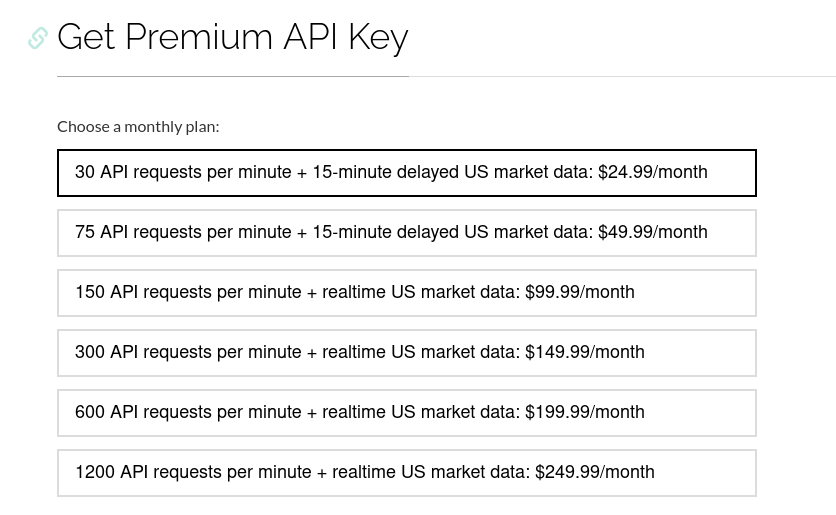  
https://www.alphavantage.co/premium/

In [13]:
ts = TimeSeries(key='RRLFQ7GUQ5ZDDRI4', output_format='pandas')
data, meta_data = ts.get_intraday(symbol='CL', interval='15min', outputsize='full')
print(meta_data)
data

{'1. Information': 'Intraday (15min) open, high, low, close prices and volume', '2. Symbol': 'CL', '3. Last Refreshed': '2023-11-24 17:00:00', '4. Interval': '15min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'}


,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2023-11-24 17:00:00,77.310,77.310,77.310,77.310,183204.0
2023-11-24 15:45:00,77.370,77.370,77.370,77.370,1.0
2023-11-24 15:30:00,77.310,77.310,77.310,77.310,183204.0
2023-11-24 15:00:00,77.235,77.235,77.235,77.235,1.0
2023-11-24 14:30:00,77.100,77.100,77.100,77.100,6.0
...,...,...,...,...,...
2023-11-03 08:45:00,74.780,74.980,74.780,74.980,636.0
2023-11-03 08:30:00,74.480,74.480,74.480,74.480,22.0
2023-11-03 08:00:00,74.600,74.990,74.600,74.800,53.0


## Nasdaq 
- data only up to 2021 June
- Daily only

In [2]:
nd_data = nasdaqdatalink.get('CHRIS/CME_CL1', returns='pandas')
nd_data

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/urllib3/util/retry.py:83: DeprecationWarning:

Using 'Retry.BACKOFF_MAX' is deprecated and will be removed in v2.0. Use 'Retry.DEFAULT_BACKOFF_MAX' instead



,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1983-03-30,29.01,29.56,29.01,29.40,NaN,29.40,949.0,470.0
1983-03-31,29.40,29.60,29.25,29.29,NaN,29.29,521.0,523.0
1983-04-04,29.30,29.70,29.29,29.44,NaN,29.44,156.0,583.0
1983-04-05,29.50,29.80,29.50,29.71,NaN,29.71,175.0,623.0
1983-04-06,29.90,29.92,29.65,29.90,NaN,29.90,392.0,640.0
...,...,...,...,...,...,...,...,...
2021-06-23,72.91,74.25,72.82,73.28,0.23,73.08,422226.0,426766.0
2021-06-24,73.28,73.61,72.32,73.33,0.22,73.30,331826.0,426977.0
2021-06-25,73.32,74.18,72.85,74.00,0.75,74.05,357898.0,427257.0


## Data Bento

In [16]:
client = db.Historical(os.environ['databento'])

data = client.timeseries.get_range(
    dataset="GLBX.MDP3",
    symbols=["CLF4"],
    schema="trades",
    start="2023-11-01",
    end="2023-11-05",
    limit=800
)
df = data.to_df()
df.head()

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,symbol
ts_recv,,,,,,,,,,,,,
2023-11-01 00:00:00.282965659+00:00,2023-11-01 00:00:00.282079415+00:00,0,1,78460,T,A,0,80.86,2,0,16699,170595452,CLF4
2023-11-01 00:00:00.287575684+00:00,2023-11-01 00:00:00.285762441+00:00,0,1,78460,T,A,0,80.85,1,0,16880,170595785,CLF4
2023-11-01 00:00:00.287635022+00:00,2023-11-01 00:00:00.285773975+00:00,0,1,78460,T,A,0,80.85,1,0,15108,170595787,CLF4
2023-11-01 00:00:00.290538112+00:00,2023-11-01 00:00:00.288700161+00:00,0,1,78460,T,B,0,80.85,1,0,14342,170595961,CLF4
2023-11-01 00:00:00.307233280+00:00,2023-11-01 00:00:00.306522683+00:00,0,1,78460,T,A,0,80.83,2,0,14425,170596673,CLF4


In [17]:
df.to_csv('./data/databento.csv')

https://databento.com/portal/datasets/GLBX.MDP3/Futures/CL
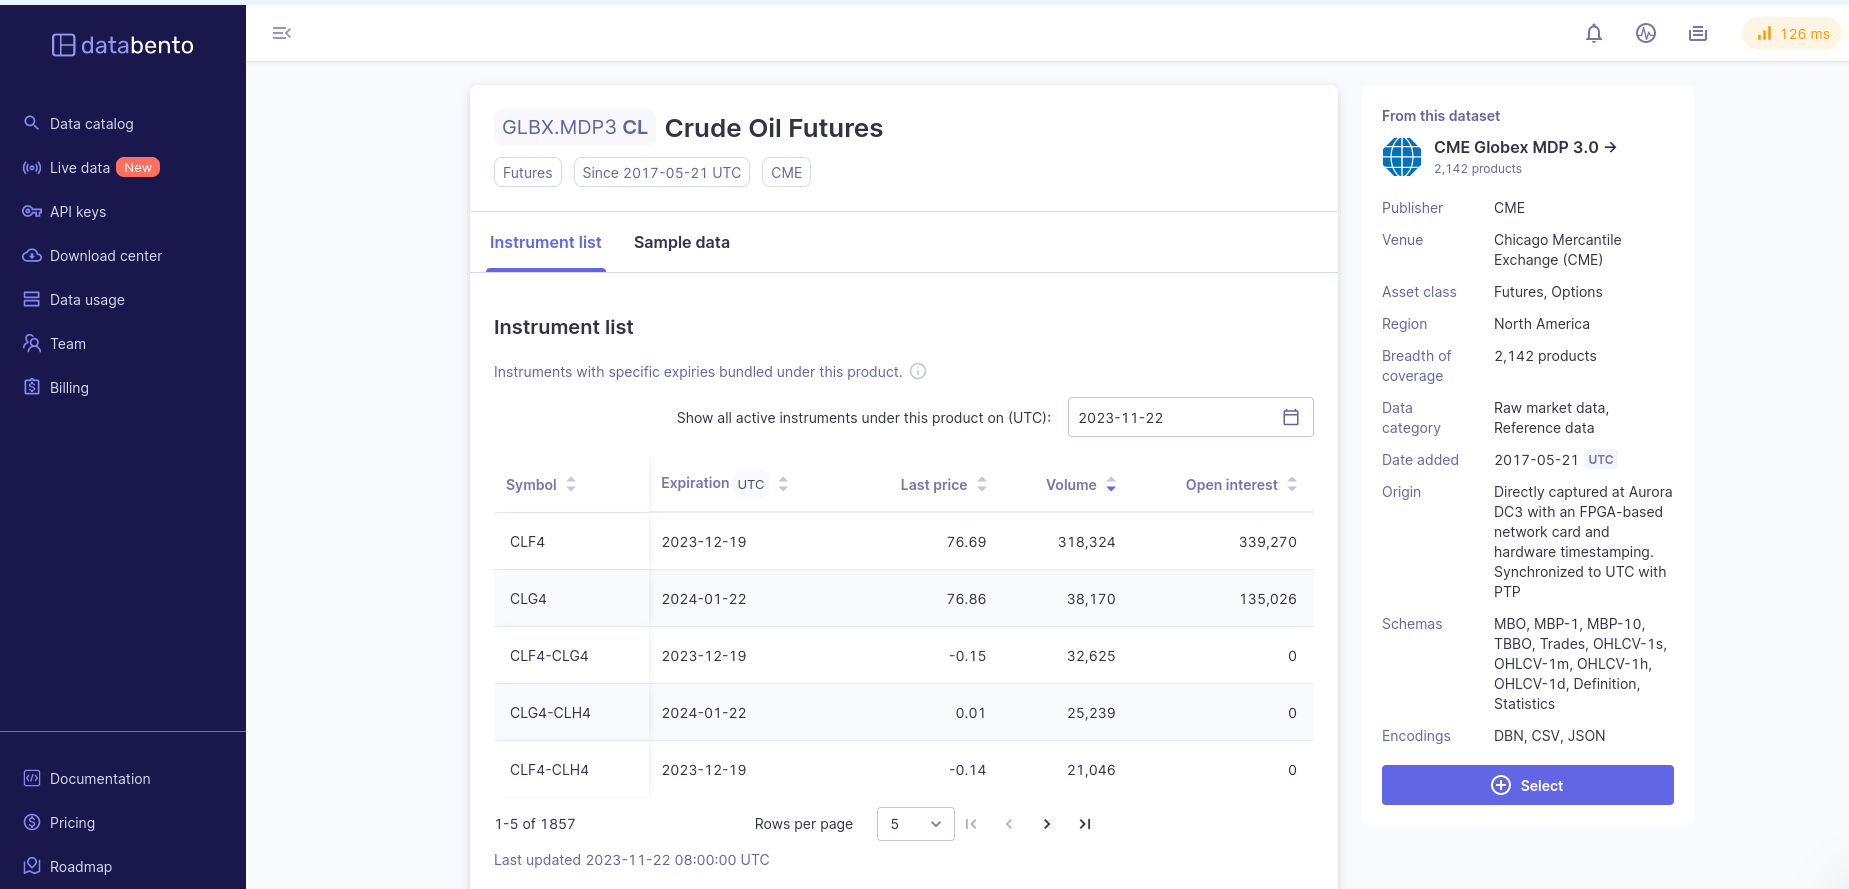

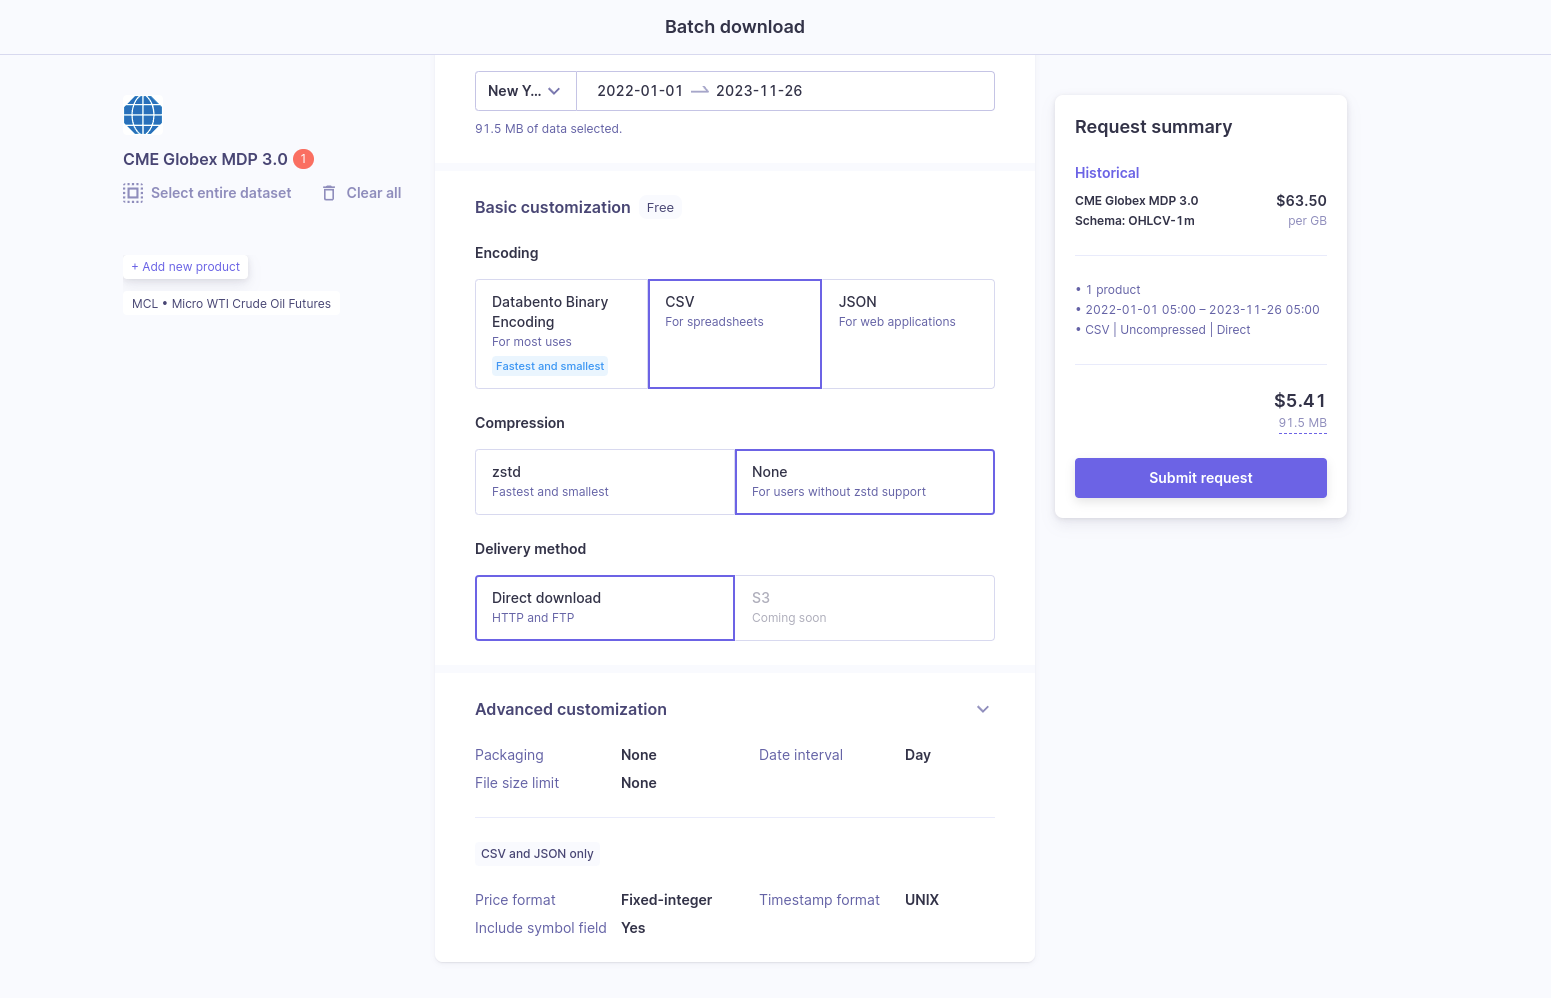

## Polygon  
https://www.youtube.com/watch?v=qUgk-wGlJg8&list=PL5auUFf6x-ly-ZVj5E_Y7nIRWf0HG4_o7&index=6    

https://github.com/polygon-io/client-python/tree/master/examples/rest  

Free version seems to have 7 - 10 days lag?

In [11]:
client = RESTClient(os.environ['polygon'])

# Fetch historical data
response = client.get_aggs(
    'CL',
    multiplier=15,
    timespan='minute',
    from_='2023-06-01',
    to='2023-11-25',
    limit=50000
)

df = pd.DataFrame(response)
df['time'] = df['timestamp'].apply(lambda x: pd.to_datetime(x*1000000))

df

,open,high,low,close,volume,vwap,timestamp,transactions,otc,time
0,74.580,74.580,74.580,74.58,116.0,74.5800,1685619000000,2.0,None,2023-06-01 11:30:00
1,75.000,75.040,74.980,75.04,3300.0,75.0001,1685625300000,31.0,None,2023-06-01 13:15:00
2,74.910,75.020,74.665,74.82,220476.0,74.8717,1685626200000,2096.0,None,2023-06-01 13:30:00
3,74.835,74.960,74.670,74.72,123286.0,74.8353,1685627100000,1839.0,None,2023-06-01 13:45:00
4,74.705,75.270,74.680,75.11,307341.0,75.0202,1685628000000,4772.0,None,2023-06-01 14:00:00
...,...,...,...,...,...,...,...,...,...,...
3687,77.265,77.265,77.130,77.14,79663.0,77.1769,1700846100000,1337.0,None,2023-11-24 17:15:00
3688,77.130,77.150,77.070,77.13,77289.0,77.1136,1700847000000,1360.0,None,2023-11-24 17:30:00
3689,77.135,77.340,77.085,77.30,181057.0,77.1866,1700847900000,2891.0,None,2023-11-24 17:45:00
3690,77.310,77.310,77.310,77.31,183204.0,77.3100,1700848800000,1.0,None,2023-11-24 18:00:00


In [54]:
priceData = df.set_index('time')

fig = go.Figure(
    data=[go.Candlestick(x=priceData.index,
    open=priceData['open'],
    high=priceData['high'],
    low=priceData['low'],
    close=priceData['close'])]
)

plot(fig, auto_open=True)

'temp-plot.html'

Gtk-Message: 12:51:51.154: Failed to load module "canberra-gtk-module"
Gtk-Message: 12:51:51.155: Failed to load module "canberra-gtk-module"


Opening in existing browser session.


In [5]:
news = []
for n in client.list_ticker_news("CL", order="desc", limit=200):
    news.append(n)

# print(news)

# print date + title
for index, item in enumerate(news):
    # verify this is an agg
    if isinstance(item, TickerNews):
        print("{:<25}{:<15}".format(item.published_utc, item.title))

2023-11-15T15:56:00Z     Cresco Labs’ stock rises as revenue beats analyst estimate
2023-11-14T15:07:00Z     The Smartest Dividend Stocks to Buy With $400 Right Now
2023-11-13T14:00:39Z     The Latest Analyst Ratings for Colgate-Palmolive
2023-11-05T12:20:00Z     If You Like Dividends, You Should Love These 3 Stocks
2023-11-01T13:50:07Z     Why Colgate-Palmolive (CL) is a Top Momentum Stock for the Long-Term
2023-11-01T13:30:02Z     Colgate-Palmolive (CL) Recently Broke Out Above the 200-Day Moving Average
2023-10-31T20:53:00Z     These 3 Companies Delivered Beat-and-Raise Quarters
2023-10-31T14:27:00Z     Monster Beverage (MNST) Looks Poised for Q3 Earnings Beat
2023-10-30T13:44:00Z     Zacks Industry Outlook Highlights The Procter & Gamble, Colgate-Palmolive and Church & Dwight
2023-10-30T07:40:15Z     Apple, AMD, Palantir Earnings On Deck This Week As Market Seeks Positive Catalysts In Fed Decision Week
2023-10-28T13:45:00Z     Meta's Plans, Cyberattacks, and the EV Race
2023-10-27T

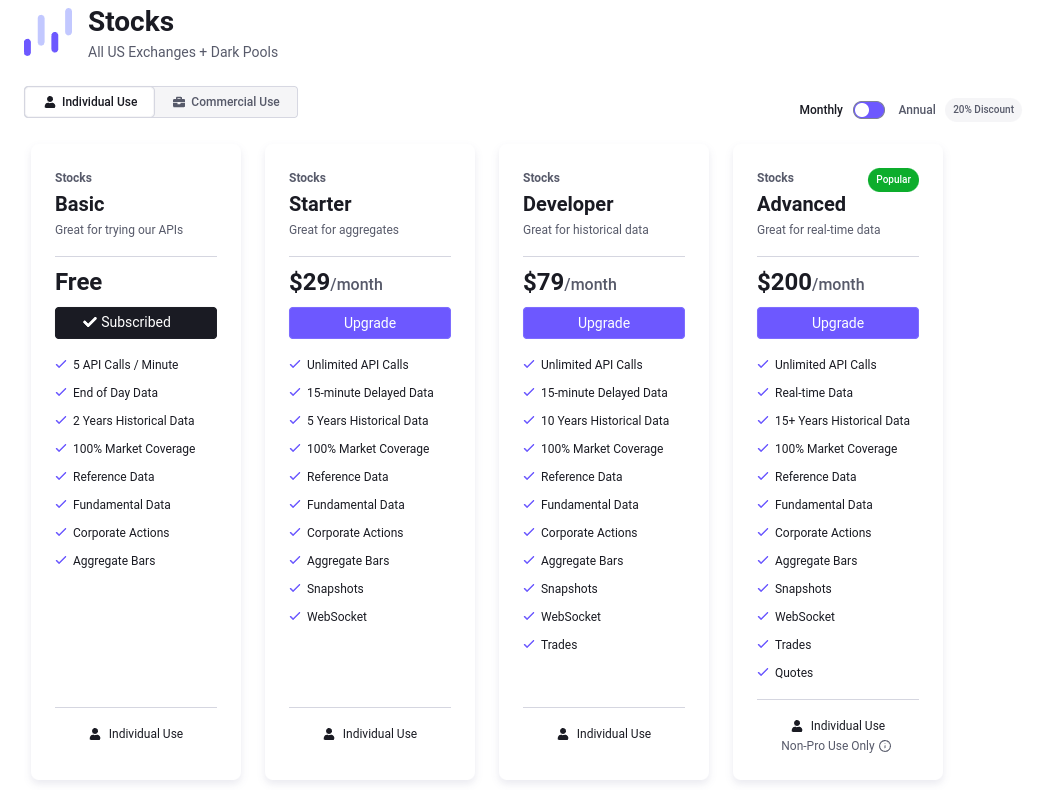

## Twelve Data

In [13]:
td = TDClient(apikey=os.environ['twelvedata'])
ts = td.time_series(
    symbol='GOLD',
    interval='15min',
    timezone='America/New_York',
    start_date='2019-11-01',
    end_date='2023-11-28',
    outputsize=5000,
    # exchange='NYMEX'
)

df = ts.as_pandas()
# df.to_csv('data/twelvedata.csv')
df

,open,high,low,close,volume
datetime,,,,,
2023-11-27 15:45:00,16.5800,16.590,16.550,16.5600,1395168
2023-11-27 15:30:00,16.5850,16.610,16.560,16.5850,713107
2023-11-27 15:15:00,16.6150,16.620,16.580,16.5800,353381
2023-11-27 15:00:00,16.6150,16.640,16.595,16.6150,607856
2023-11-27 14:45:00,16.6150,16.630,16.590,16.6168,383243
...,...,...,...,...,...
2023-02-22 12:00:00,16.1900,16.200,16.165,16.1850,671533
2023-02-22 11:45:00,16.1900,16.215,16.160,16.1965,837381
2023-02-22 11:30:00,16.2600,16.265,16.190,16.1950,737881


## Finnhub

In [2]:
finnhub_client = finnhub.Client(api_key=os.environ['finnhub'])

In [12]:
res = finnhub_client.stock_candles('CL', '15min', 1590988249, 1591852249)

FinnhubAPIException: FinnhubAPIException(status_code: 422): Wrong resolution. Please check the documentation for further details.

In [10]:
pd.DataFrame(res)

,c,h,l,o,s,t,v
0,72.73,72.99,71.9600,72.27,ok,1590969600,2641016
1,72.44,73.11,71.6300,72.65,ok,1591056000,3751307
2,71.65,72.90,71.6100,72.90,ok,1591142400,4536015
3,70.75,72.35,70.5900,71.42,ok,1591228800,4985760
4,72.40,72.58,70.2900,71.17,ok,1591315200,5976607
5,73.51,73.54,71.7600,71.94,ok,1591574400,5033397
6,73.28,73.56,72.1400,73.29,ok,1591660800,4608065
7,74.36,74.90,73.4276,73.74,ok,1591747200,5726568
8,73.10,75.00,72.8200,73.85,ok,1591833600,5547337


## Other paid sources:
1. https://portaracqg.com/pricing/  
1. https://www.backtestmarket.com/en/crude-oil-pack-back-adjusted  
1. https://www.tickdatamarket.com/tarifs.php?famille=futures&type=individuel
1. https://marketstack.com/documentation [missing data as well]
1. https://commodities-api.com/ [looks promising]

#3 includes bid-ask data that could be useful alongside candlestick data.

__Liquidity Analysis__: Bid-ask data can indicate market liquidity. A tighter bid-ask spread generally suggests a more liquid market, while a wider spread might indicate lower liquidity or higher volatility.

__Market Sentiment__: The relationship between bid and ask prices can offer insights into market sentiment. For instance, if the ask price is consistently higher than the bid price, it might indicate bullish sentiment (expectation of rising prices) in the market for crude oil.

__Trade Execution Strategies__: Understanding bid-ask dynamics can help in optimizing trade execution strategies. For instance, the depth of the bid-ask stack (the number of buyers and sellers at different prices) can guide decisions on when and at what price to execute a trade.

__Price Prediction Models__: Including bid-ask data alongside candlestick patterns might improve the accuracy of price prediction models. It can offer a more comprehensive view of the market dynamics that influence crude oil prices.

### References  
1. https://treasuryone.co.za/understanding-the-gold-oil-ratio/  
1. https://blog.gorozen.com/blog/the-gold-oil-ratio-revisited  
1. https://aheadoftheherd.com/gold-oil-ratio-points-to-higher-gold-prices/

## Some Plots  
> lunch break can be determined by general cease of trading activities in certain hours

In [38]:
df = yf.download('CL=F', interval='15m', start=datetime.today() - timedelta(days=60), end=datetime.today())
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-26 10:00:00,89.739998,89.820000,89.360001,89.389999,89.389999,7019
2023-09-26 10:15:00,89.389999,89.949997,89.309998,89.879997,89.879997,11142
2023-09-26 10:30:00,89.879997,90.339996,89.870003,90.239998,90.239998,14934
2023-09-26 10:45:00,90.230003,90.360001,90.059998,90.160004,90.160004,8808
2023-09-26 11:00:00,90.160004,90.570000,90.040001,90.440002,90.440002,10970


In [44]:
df.index = pd.to_datetime(df.index)
# df.index = df['time']
wednesdays = df[df.index.dayofweek == 2]

wednesday_groups = {}
for date, data in wednesdays.groupby(wednesdays.index.date):
    wednesday_groups[date] = data

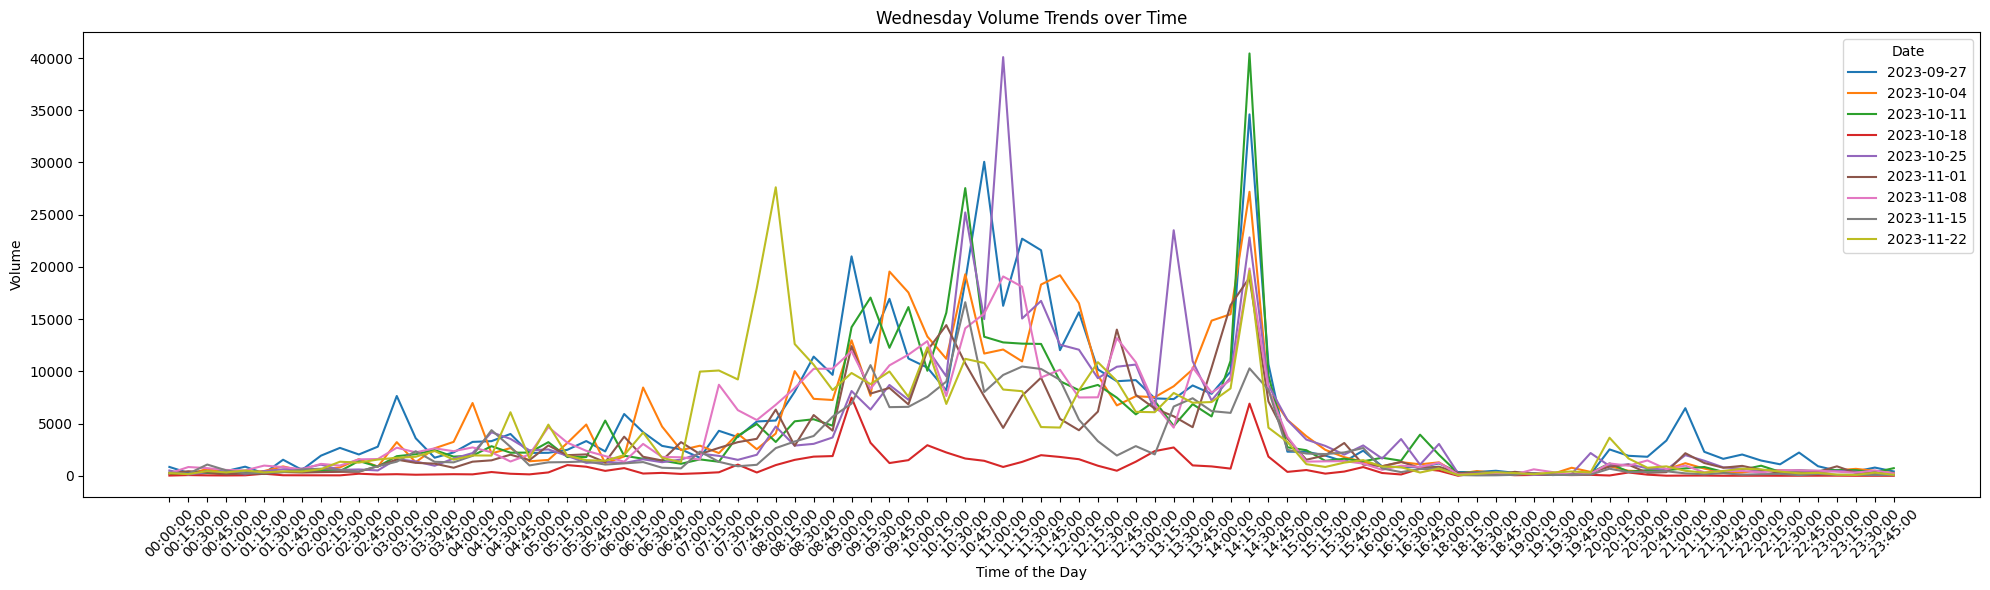

In [45]:
plt.figure(figsize=(20, 6))

for date, data in wednesday_groups.items():
    time_of_day = data.index.strftime('%H:%M:%S')  # Extracting time, ignoring the date
    plt.plot(time_of_day, data['Volume'], label=str(date))

plt.xlabel('Time of the Day')
plt.ylabel('Volume')
plt.title('Wednesday Volume Trends over Time')
plt.xticks(rotation=45)
plt.legend(title='Date')
plt.tight_layout()

plt.show()

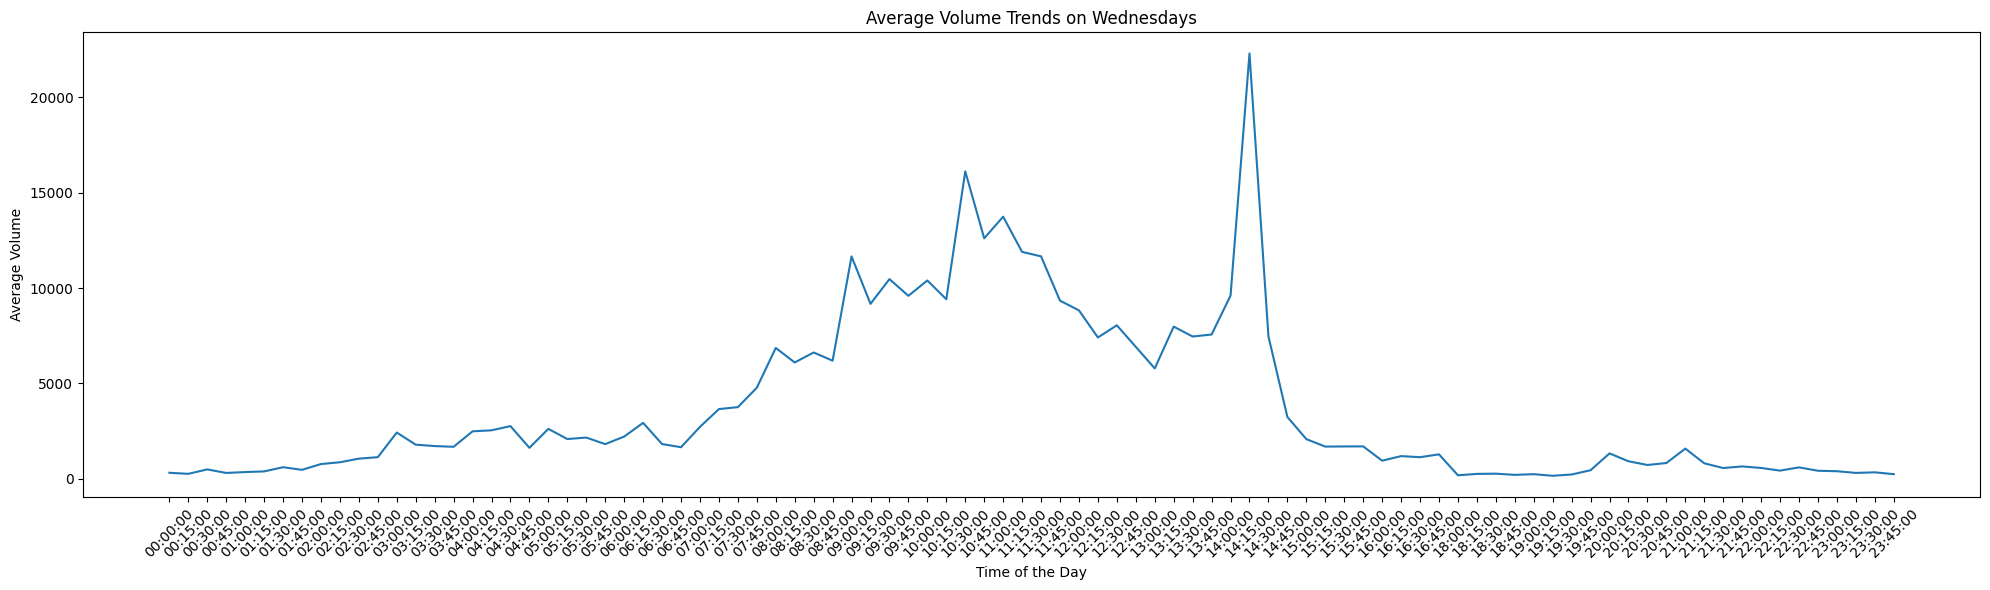

In [46]:
grouped = wednesdays.groupby(wednesdays.index.strftime('%H:%M:%S'))['Volume'].mean()

# Convert the index to datetime for plotting
grouped.index = pd.to_datetime(grouped.index)

# Create a plot for the average volume over time
plt.figure(figsize=(20, 6))

# Plotting the average volume over time
plt.plot(grouped.index.strftime('%H:%M:%S'), grouped.values)

# Adding labels and title
plt.xlabel('Time of the Day')
plt.ylabel('Average Volume')
plt.title('Average Volume Trends on Wednesdays')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show plot
plt.show()

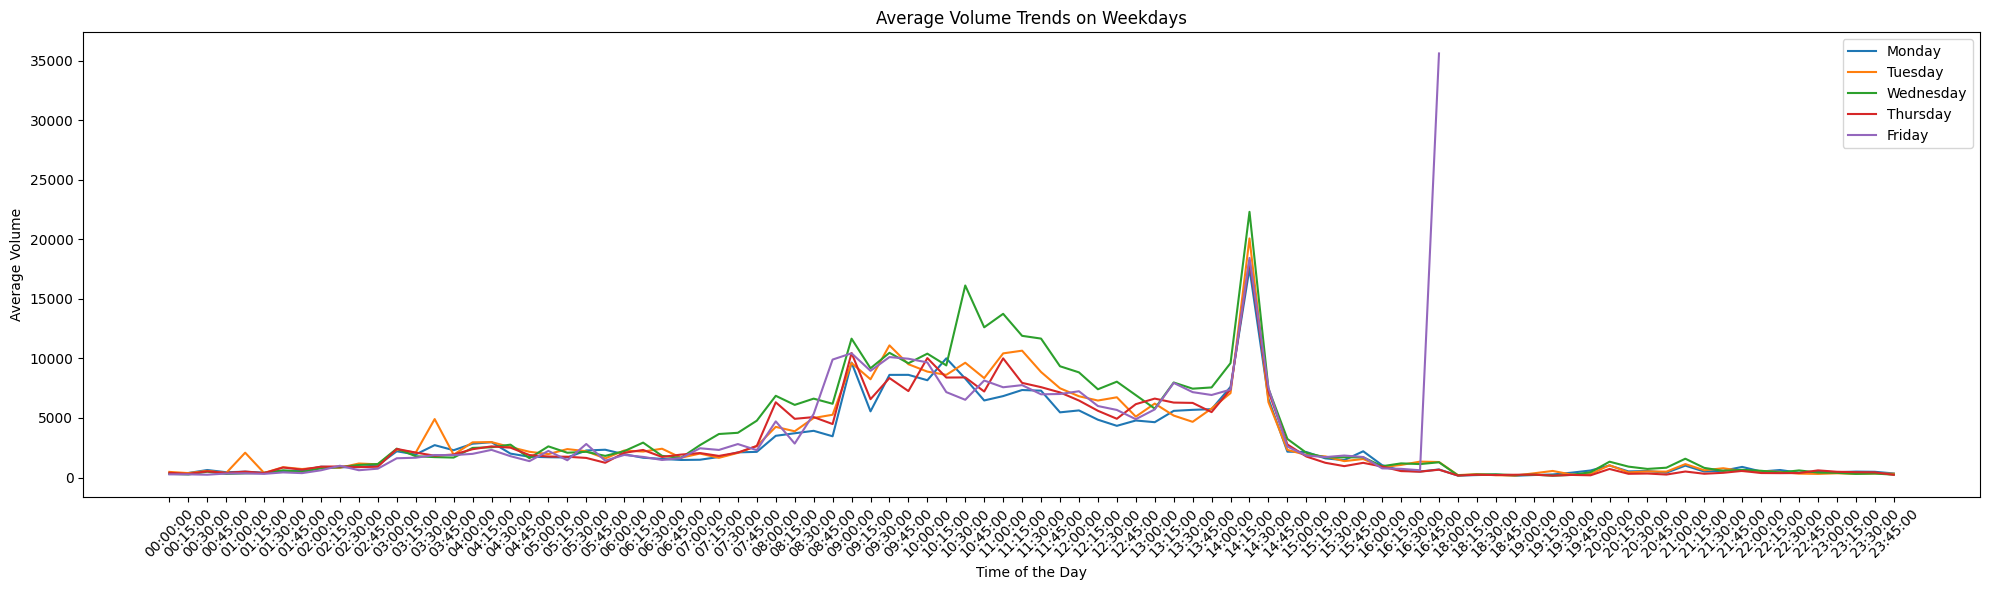

In [47]:
weekdays = df[df.index.dayofweek < 5]  # 0-4 corresponds to Monday to Friday

# Group by day of the week and time of the day, calculate the average volume for each time interval
grouped = weekdays.groupby([weekdays.index.dayofweek, weekdays.index.strftime('%H:%M:%S')])['Volume'].mean()

# Convert the multi-index to a single-level index for plotting
grouped = grouped.unstack(level=0)

# Create a plot for the average volume over time for each weekday
plt.figure(figsize=(20, 6))

day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}

# Plotting the average volume over time for each weekday
for day in range(5):
    plt.plot(grouped.index, grouped[day], label=day_names[day])

# Adding labels and title
plt.xlabel('Time of the Day')
plt.ylabel('Average Volume')
plt.title('Average Volume Trends on Weekdays')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


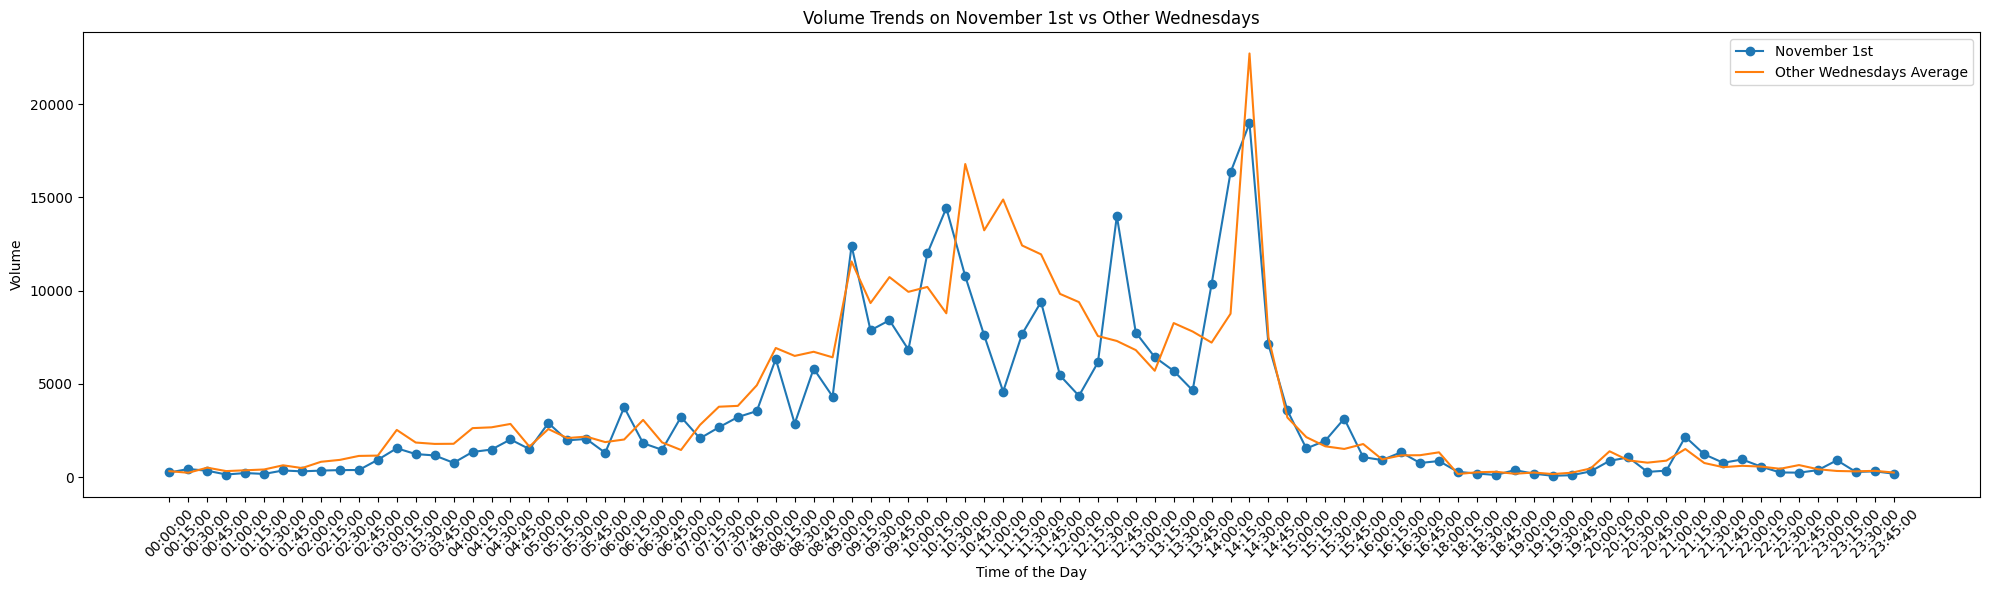

In [48]:
# Filter dataframe to include only Wednesdays excluding November 1st
wednesdays = df[(df.index.dayofweek == 2) & (~df.index.strftime('%Y-%m-%d').isin(['2023-11-01']))]

# Group by time of the day, calculate the average volume for each time interval on other Wednesdays
grouped_wednesdays = wednesdays.groupby(wednesdays.index.strftime('%H:%M:%S'))['Volume'].mean()

# Filter dataframe to include only November 1st
nov_1st = df[df.index.strftime('%Y-%m-%d') == '2023-11-01']

# Plotting November 1st
plt.figure(figsize=(20, 6))
plt.plot(nov_1st.index.strftime('%H:%M:%S'), nov_1st['Volume'], label='November 1st', marker='o')

# Plotting the average volume over time for other Wednesdays
plt.plot(grouped_wednesdays.index, grouped_wednesdays, label='Other Wednesdays Average')

# Adding labels and title
plt.xlabel('Time of the Day')
plt.ylabel('Volume')
plt.title('Volume Trends on November 1st vs Other Wednesdays')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

## Some Research About Oil Price

- The increased volatility in oil prices observed on Wednesdays might be attributed to the announcement of the interest rate decision by the FOMC which is always made around 2:00 PM ET on those days. Consequently, it's crucial to focus on Wednesdays when the FOMC conducts its meetings. 

- The dates of interest rate announcements in the past 12 months were: 13 Dec (2022), 1 Feb, 22 March, 3 May, 14 June, 26 July, 20 September, 1 November.  

- Given that there are only eight FOMC meetings annually, analyzing price behavior over the past 12 months alone might provide insufficient data to draw a conclusive assessment.  

- In addition, due to the tightening nature of the state of economy in recent years, market anticipation leaned more towards an increase in the interest rate rather than the prospect of a decrease. Given the cyclical nature of the economy, analyzing only a short timeframe may fail to capture the complete price trend of an entire cycle, potentially limiting the predictive capacity of the results obtained for future trends.  

- Suggestion: conduct a more comprehensive analysis of oil price behavior by also considering various other factors. To begin, we can examine the Gold Oil ratio, calculated by dividing the price of an ounce of gold by the price of one barrel of crude oil. Typically, gold and crude oil prices tend to exhibit a strong correlation. By analyzing their relationship, we may be able to identify potential arbitrage opportunities.  

## Time Series Models

## Testing

In [102]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,78.135600,79.346160,76.735000,78.005920,78.005920,313867.324000
std,5.870349,5.816472,5.955341,5.841710,5.841710,97586.457861
min,66.620003,67.699997,63.639999,66.739998,66.739998,0.000000
25%,73.650000,74.984999,72.340002,73.459999,73.459999,275205.500000
50%,78.020000,79.170002,76.575001,77.920002,77.920002,322535.500000
75%,81.395000,82.460001,80.099998,81.125002,81.125002,368709.750000
max,93.779999,95.029999,91.389999,93.680000,93.680000,555164.000000


In [103]:
df_data = df.reset_index()
df_data = df_data[['Date', 'Close']]
df_data = df_data.rename({'Date': 'ds', 'Close': 'y'}, axis=1)
df_data.head()

,ds,y
0,2022-11-21,79.730003
1,2022-11-22,80.949997
2,2022-11-23,77.940002
3,2022-11-25,76.279999
4,2022-11-28,77.239998


In [46]:
model = Prophet(daily_seasonality=True)
model.fit(df_data)

09:21:52 - cmdstanpy - INFO - Chain [1] start processing


09:21:52 - cmdstanpy - INFO - Chain [1] done processing


In [114]:
future = model.make_future_dataframe(periods=365)
prediction = model.predict(future)
model.plot(prediction)
plt.title('Prediction of Price')
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
# plt.show()

<IPython.core.display.Javascript object>

Text(94.44444444444444, 0.5, 'Close Stock Price')

In [105]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-21,79.106952,74.521253,82.484337,79.106952,79.106952,-1.003440,-1.003440,-1.003440,-1.1209,-1.1209,-1.1209,0.117460,0.117460,0.117460,0.0,0.0,0.0,78.103512
1,2022-11-22,79.090646,73.905580,82.169452,79.090646,79.090646,-0.954711,-0.954711,-0.954711,-1.1209,-1.1209,-1.1209,0.166189,0.166189,0.166189,0.0,0.0,0.0,78.135935
2,2022-11-23,79.074340,73.729854,81.776647,79.074340,79.074340,-1.356838,-1.356838,-1.356838,-1.1209,-1.1209,-1.1209,-0.235938,-0.235938,-0.235938,0.0,0.0,0.0,77.717502
3,2022-11-25,79.041727,73.898802,82.096726,79.041727,79.041727,-1.097615,-1.097615,-1.097615,-1.1209,-1.1209,-1.1209,0.023285,0.023285,0.023285,0.0,0.0,0.0,77.944112
4,2022-11-28,78.992808,73.842305,81.929091,78.992808,78.992808,-1.003440,-1.003440,-1.003440,-1.1209,-1.1209,-1.1209,0.117460,0.117460,0.117460,0.0,0.0,0.0,77.989368


<IPython.core.display.Javascript object>

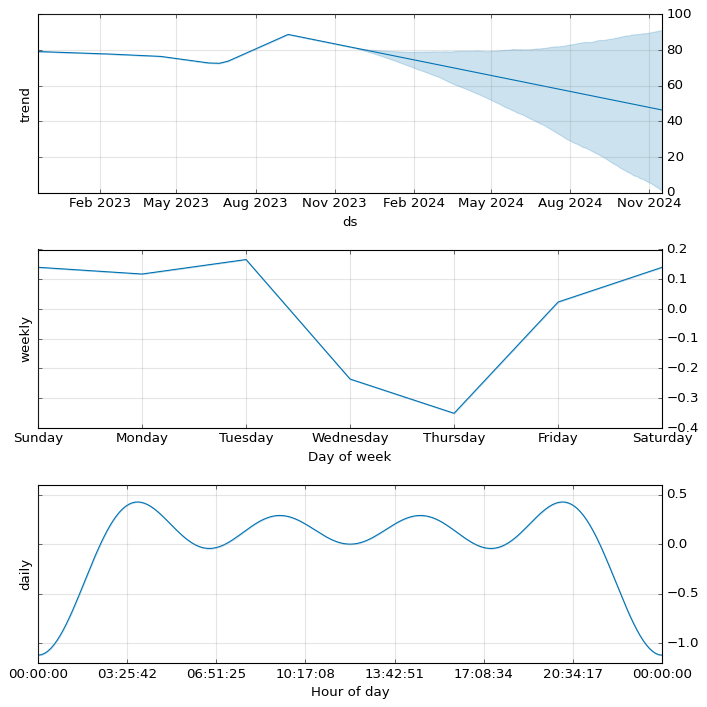

In [110]:
model.plot_components(prediction)
# plt.show()

In [107]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-21,80.300003,80.300003,75.080002,79.730003,79.730003,475104
2022-11-22,80.220001,82.360001,79.849998,80.949997,80.949997,269615
2022-11-23,81.080002,81.949997,76.830002,77.940002,77.940002,379145
2022-11-25,77.510002,79.900002,76.220001,76.279999,76.279999,266451
2022-11-28,75.930000,77.839996,73.599998,77.239998,77.239998,405033
...,...,...,...,...,...,...
2023-11-13,77.150002,78.639999,76.209999,78.260002,78.260002,262903
2023-11-14,78.529999,79.769997,77.790001,78.260002,78.260002,263002
2023-11-15,78.169998,78.769997,76.309998,76.660004,76.660004,282301


In [115]:
# Simple Moving Average Crossover

result, plot = backtest('smac', df, fast_period=15, slow_period=40, verbose=True, return_plot=True)
result

Starting Portfolio Value: 100000.00
2023-11-17T00:00:00, ===Global level arguments===
2023-11-17T00:00:00, init_cash : 100000
2023-11-17T00:00:00, buy_prop : 1
2023-11-17T00:00:00, sell_prop : 1
2023-11-17T00:00:00, commission : 0
2023-11-17T00:00:00, stop_loss : 0
2023-11-17T00:00:00, stop_trail : 0
2023-11-17T00:00:00, take_profit : 0
2023-11-17T00:00:00, allow_short : False
===Strategy level arguments===
fast_period : 15
slow_period : 40
2023-11-17T00:00:00, Final Portfolio Value: 104617.06562042236
2023-11-17T00:00:00, Final PnL: 4617.07
Time used (seconds): 0.08986663818359375
Number of strat runs: 1
Number of strats per run: 1
Strat names: ['smac']
**************************************************
--------------------------------------------------
Strategy Parameters	init_cash:100000	buy_prop:1	sell_prop:1	fractional:False	slippage:0.001	single_position:None	commission:0	stop_loss:0	stop_trail:0	take_profit:0	execution_type:close	channel:	symbol:	allow_short:False	short_max:1.5	

<IPython.core.display.Javascript object>

,strat_id,init_cash,buy_prop,sell_prop,fractional,slippage,single_position,commission,stop_loss,stop_trail,...,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,False,0.001,None,0,0,0,...,1,1,14870.309639,14.87031,-10253.244019,-10.253244,14870.309639,14.87031,-10253.244019,-10.253244


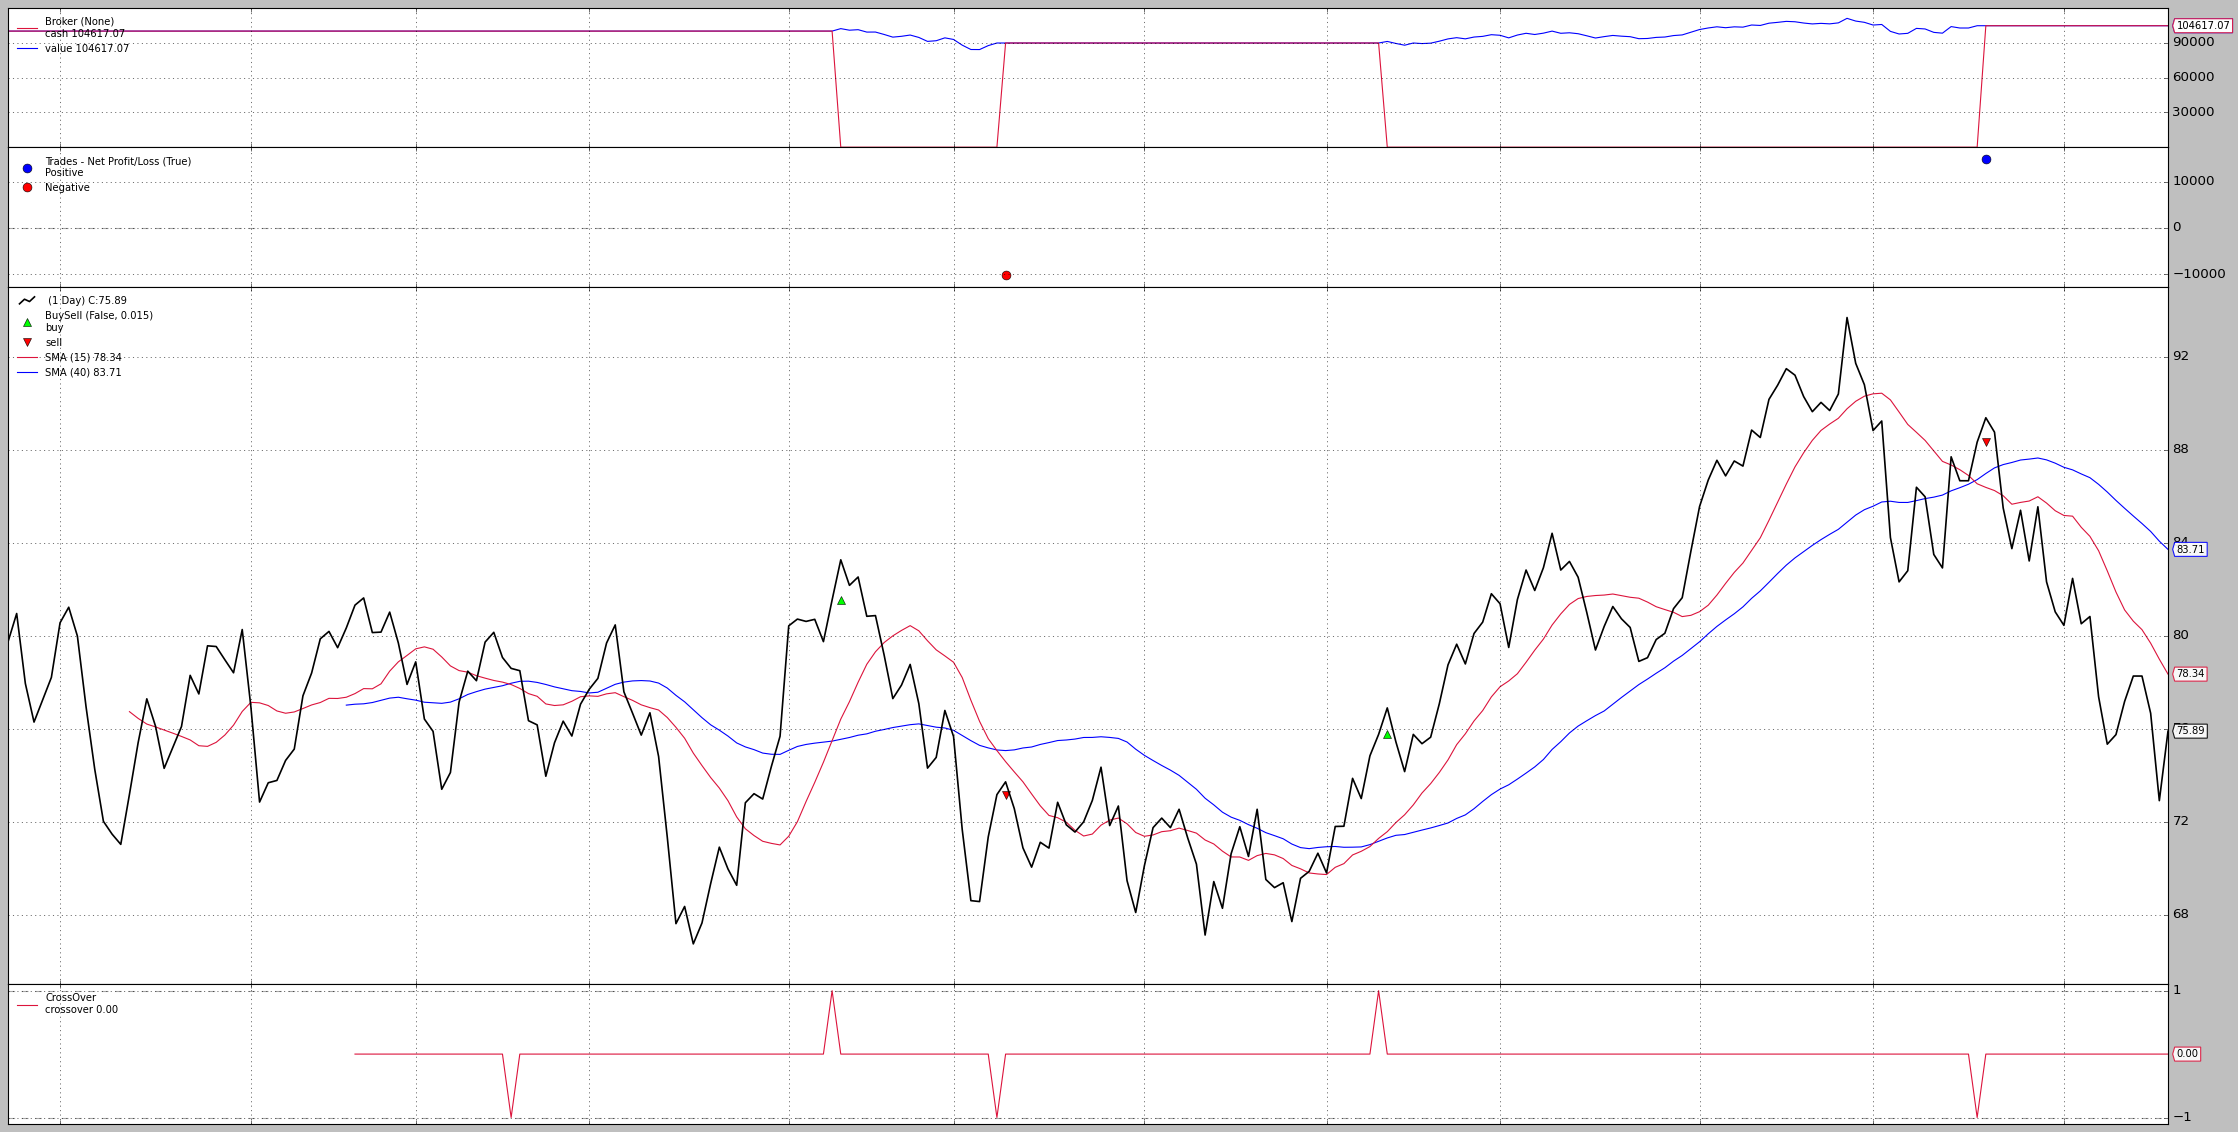

In [116]:
plot